# Heart Attack Prediction
This notebook builds a machine learning model to predict heart disease using the UCI Heart Disease dataset.
The dataset contains 303 samples with 13 features and a binary target (`output`: 1 = heart disease, 0 = no heart disease).
Features include age, sex, chest pain type (cp), resting blood pressure (trtbps), cholesterol (chol), etc.
The workflow includes data exploration, preprocessing, model training, evaluation, and prediction.

In [2]:
# Install required libraries (run in terminal or environment if needed)
# !pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn
# Note: Outputs will show installation status if libraries are not already installed.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

# Set random seed for reproducibility
np.random.seed(42)

In [5]:
# Load UCI Heart Disease dataset
df = pd.read_csv('heart.csv')

# Remove duplicates
df = df.drop_duplicates()

# Verify dataset
print('Shape:', df.shape)  # Expected: (302, 14) after removing 1 duplicate
print(df.info())  # Expected: 14 columns, no missing values
print(df.describe())  # Expected: Summary statistics for numeric features
print('Missing values:\n', df.isnull().sum())  # Expected: All zeros
print('Duplicates:', df.duplicated().sum())  # Expected: 0
df.head()  # Expected: First 5 rows of dataset

Shape: (302, 14)
<class 'pandas.core.frame.DataFrame'>
Index: 302 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       302 non-null    int64  
 1   sex       302 non-null    int64  
 2   cp        302 non-null    int64  
 3   trtbps    302 non-null    int64  
 4   chol      302 non-null    int64  
 5   fbs       302 non-null    int64  
 6   restecg   302 non-null    int64  
 7   thalachh  302 non-null    int64  
 8   exng      302 non-null    int64  
 9   oldpeak   302 non-null    float64
 10  slp       302 non-null    int64  
 11  caa       302 non-null    int64  
 12  thall     302 non-null    int64  
 13  output    302 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 35.4 KB
None
             age         sex          cp      trtbps        chol         fbs  \
count  302.00000  302.000000  302.000000  302.000000  302.000000  302.000000   
mean    54.42053    0.682119    0.963576  

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


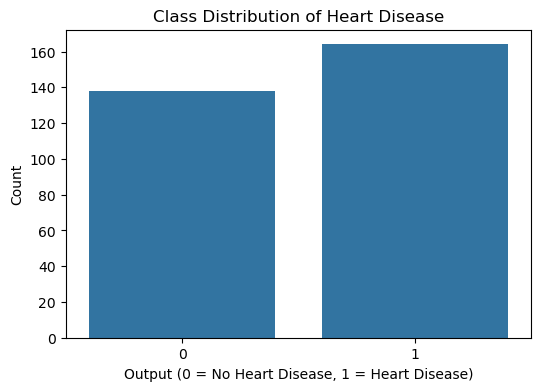

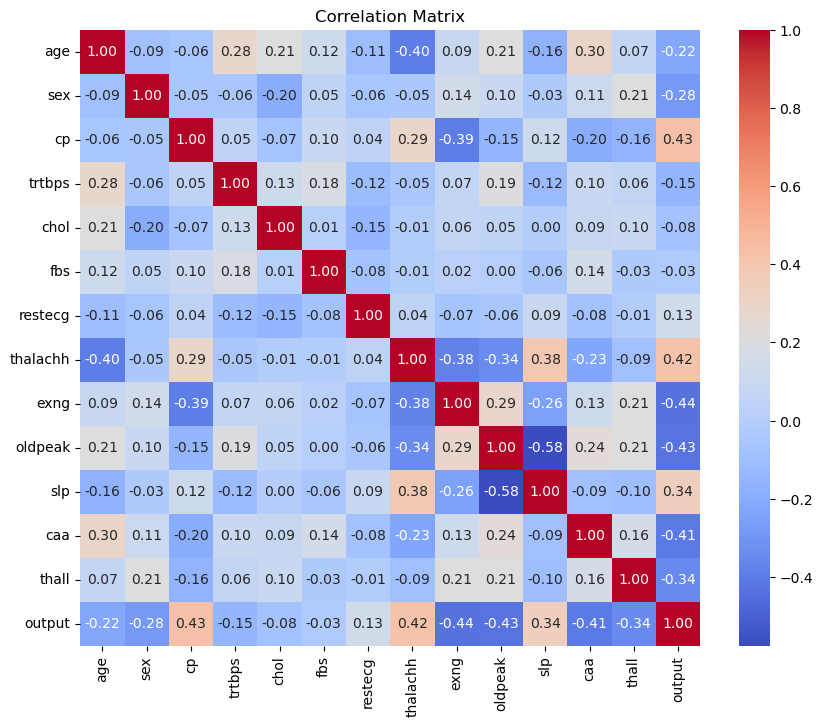

In [7]:
# Visualize class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='output', data=df)
plt.title('Class Distribution of Heart Disease')
plt.xlabel('Output (0 = No Heart Disease, 1 = Heart Disease)')
plt.ylabel('Count')
plt.show()  # Expected: Bar plot showing counts of 0 and 1 classes

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()  # Expected: Heatmap with correlation values

In [9]:
# Check if categorical features need encoding
# Features like cp, restecg, slp, caa, thall are categorical but appear pre-encoded as integers
# If raw categorical values were present, we would use pd.get_dummies here
print('Unique values in categorical features:')
for col in ['cp', 'restecg', 'slp', 'caa', 'thall']:
    print(f'{col}: {df[col].unique()}')  # Expected: Integer values indicating pre-encoding

Unique values in categorical features:
cp: [3 2 1 0]
restecg: [0 1 2]
slp: [0 2 1]
caa: [0 2 1 3 4]
thall: [1 2 3 0]


In [11]:
# Split data into features and target
X = df.drop('output', axis=1)
y = df['output']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize models
lr = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)
svm = SVC(probability=True, random_state=42)

# Train models
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
svm.fit(X_train, y_train)

# Cross-validation scores
print('Cross-validation ROC-AUC scores:')
for model, name in [(lr, 'LogisticRegression'), (rf, 'RandomForestClassifier'), (svm, 'SVC')]:
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    print(f'{name}: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})')
    # Expected: Mean ROC-AUC scores with standard deviation for each model

Cross-validation ROC-AUC scores:
LogisticRegression: 0.895 (+/- 0.102)
RandomForestClassifier: 0.912 (+/- 0.054)
SVC: 0.899 (+/- 0.071)


Evaluating Logistic Regression
Accuracy: 0.8360655737704918
Confusion Matrix:
 [[25  4]
 [ 6 26]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83        29
           1       0.87      0.81      0.84        32

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61

ROC AUC Score: 0.9224137931034484
Evaluating Random Forest
Accuracy: 0.8688524590163934
Confusion Matrix:
 [[26  3]
 [ 5 27]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87        29
           1       0.90      0.84      0.87        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61

ROC AUC Score: 0.9326508620689655
Evaluating SVM
Accuracy: 0.8688524590163

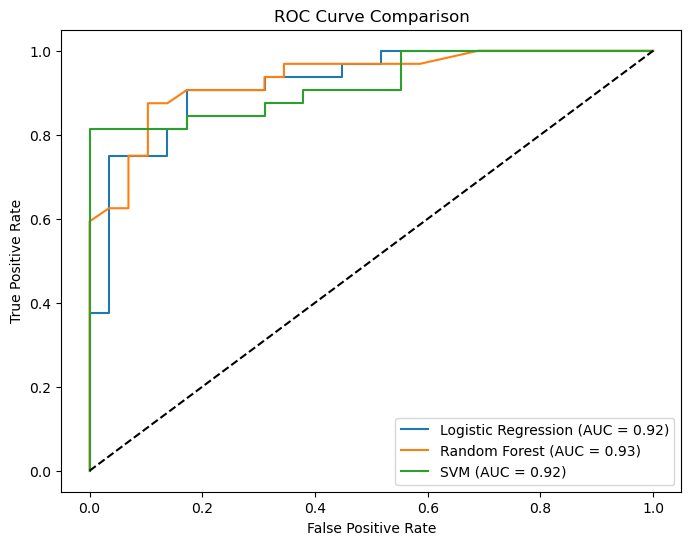

In [12]:
# Evaluate models and plot ROC curves
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    print(f'Evaluating {model_name}')
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
    print('Classification Report:\n', classification_report(y_test, y_pred))
    
    y_prob = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    print('ROC AUC Score:', auc)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')

plt.figure(figsize=(8, 6))
evaluate_model(lr, X_test, y_test, 'Logistic Regression')
evaluate_model(rf, X_test, y_test, 'Random Forest')
evaluate_model(svm, X_test, y_test, 'SVM')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()  # Expected: ROC curves for all models with AUC scores

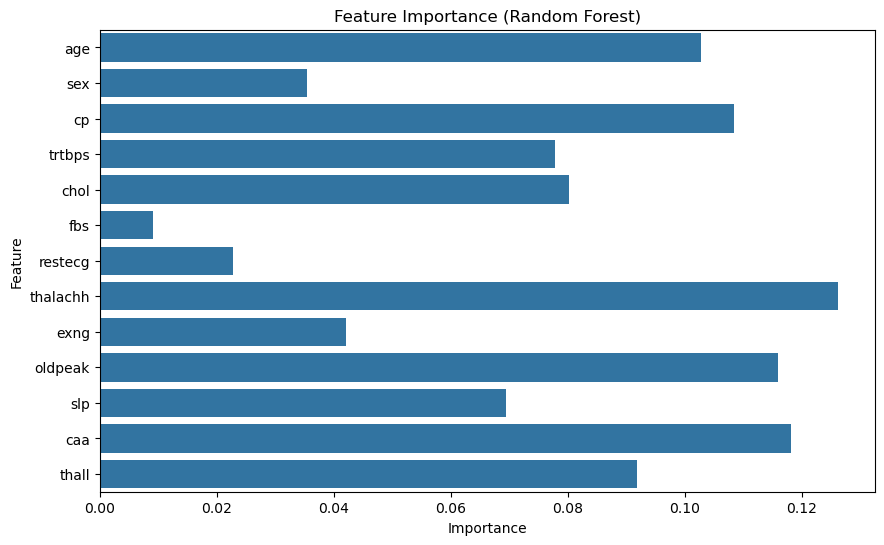

In [15]:
# Feature importance for Random Forest
importances = rf.feature_importances_
feature_names = X.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()  # Expected: Bar plot showing feature importance scores

In [17]:
# Save the trained Random Forest model
joblib.dump(rf, 'heart_attack_rf_model.pkl')
# Expected: Saves model to 'heart_attack_rf_model.pkl'

['heart_attack_rf_model.pkl']

In [19]:
# Predict on new patient data with input validation
def validate_input(sample, feature_ranges):
    for i, (value, (min_val, max_val)) in enumerate(zip(sample[0], feature_ranges)):
        if not (min_val <= value <= max_val):
            raise ValueError(f'Feature {i} ({X.columns[i]}) value {value} out of range [{min_val}, {max_val}]')

# Define feature ranges based on UCI Heart Disease dataset
feature_ranges = [
    (29, 77),  # age
    (0, 1),    # sex
    (0, 3),    # cp
    (94, 200), # trtbps
    (126, 564),# chol
    (0, 1),    # fbs
    (0, 2),    # restecg
    (71, 202), # thalachh
    (0, 1),    # exng
    (0, 6.2),  # oldpeak
    (0, 2),    # slp
    (0, 4),    # caa
    (0, 3)     # thall
]

# Example new patient input
sample = np.array([[52, 1, 0, 130, 200, 0, 1, 180, 0, 1.0, 1, 0, 2]])
validate_input(sample, feature_ranges)
sample_scaled = scaler.transform(sample)
prediction = rf.predict(sample_scaled)
probability = rf.predict_proba(sample_scaled)[0, 1]
print('Prediction:', 'Heart Disease' if prediction[0] == 1 else 'No Heart Disease')
print('Probability of Heart Disease:', f'{probability:.2f}')
# Expected: Prediction (e.g., 'Heart Disease') and probability score

Prediction: Heart Disease
Probability of Heart Disease: 0.93


## Notes
- The dataset must be in the same directory as the notebook (`heart.csv`).
- Categorical features (cp, restecg, slp, caa, thall) are assumed pre-encoded as integers.
- For hyperparameter tuning, consider using GridSearchCV (commented below for reference):
```python
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print('Best parameters:', grid_search.best_params_)
rf = grid_search.best_estimator_

In [22]:
import joblib

# Load the model
model = joblib.load('heart_attack_rf_model.pkl')

# Optional: test the model
print(model)


RandomForestClassifier(random_state=42)


In [25]:
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']